<center>

# DSC680 Applied Data Science 

## Week 8

## Term Project - 1 

## AI-Driven Retail Optimization: Demand Prediction, Inventory Management, and Pricing Strategy

### Karthika Velingiri

### 03-January-2026

</center>

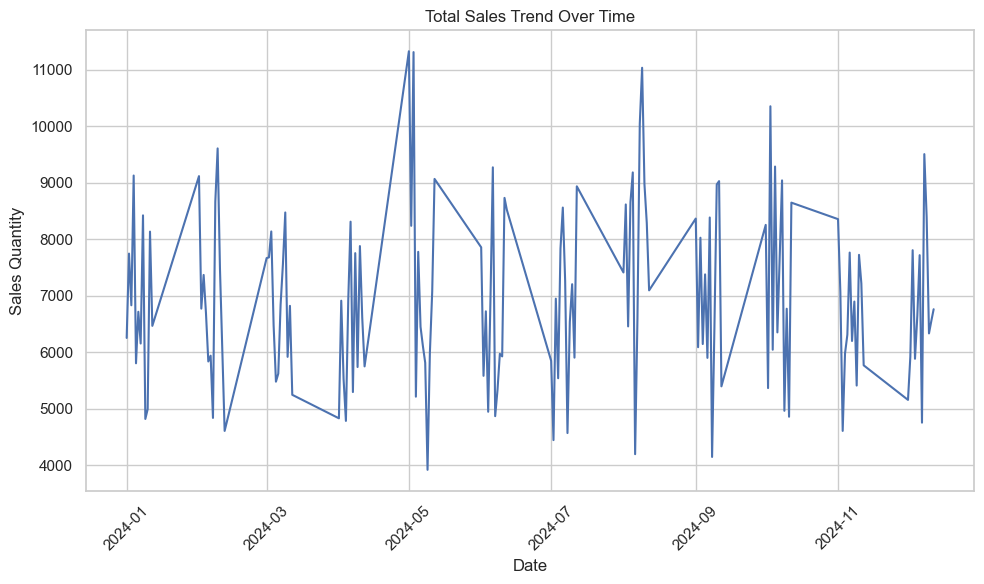

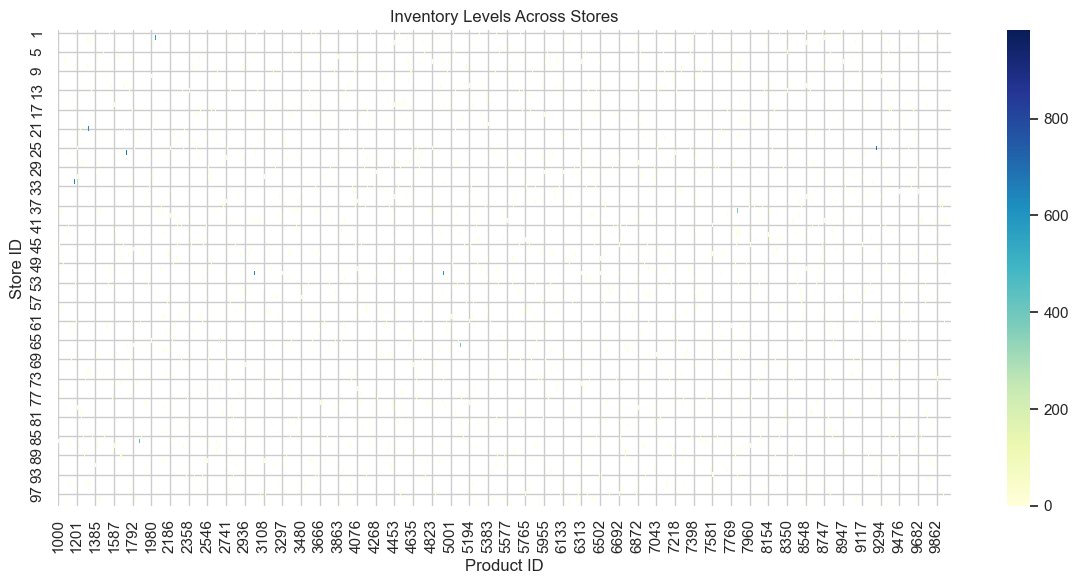

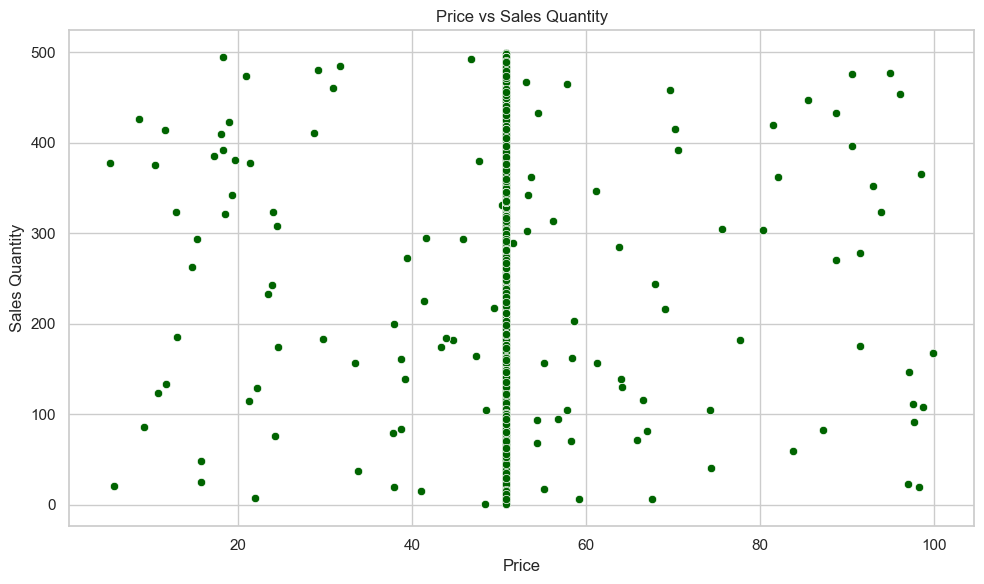

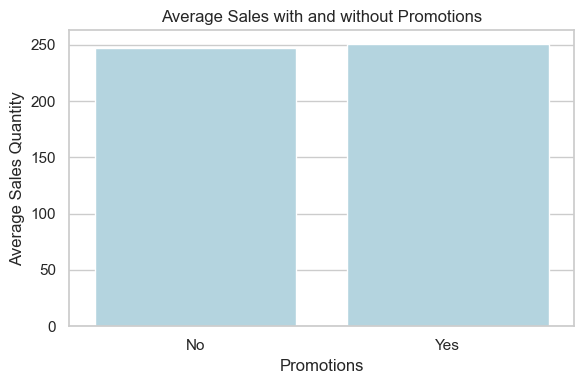

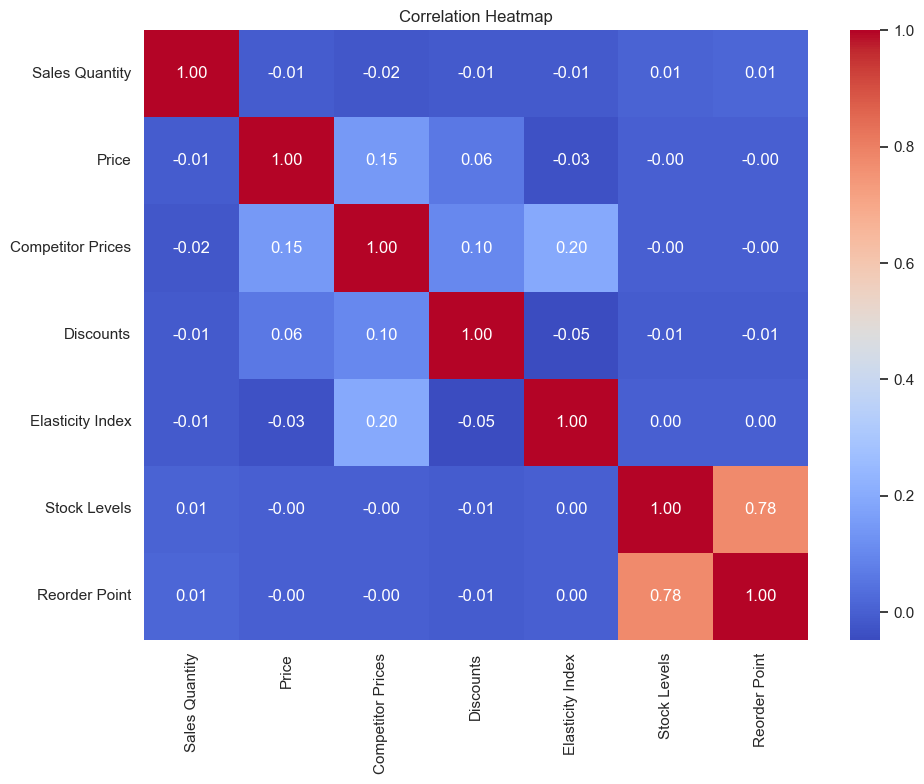

=== Random Forest Model Evaluation ===
  Metric      Value
     MAE 125.554351
    RMSE 146.296244
R2 Score  -0.036342


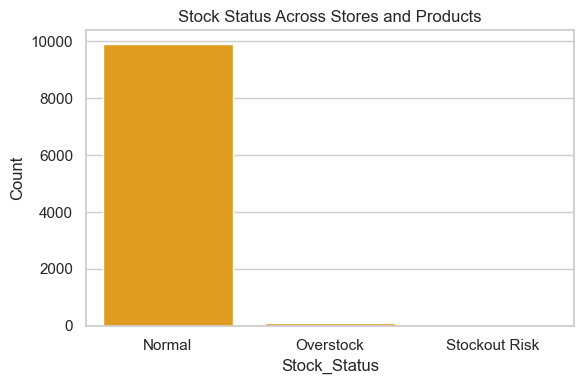

In [1]:
# ========================================
# Milestone-3: AI-Driven Retail Optimization
# Full Workflow: Cleaning → EDA → Feature Engineering → Modeling → Evaluation
# ========================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -------------------------------
# 1. Setup
# -------------------------------
sns.set(style='whitegrid')  # Plot style

# -------------------------------
# 2. Load Datasets
# -------------------------------
df_demand = pd.read_csv('../data/demand_forecasting.csv', parse_dates=['Date'], dayfirst=True)
df_inventory = pd.read_csv('../data/inventory_monitoring.csv')
df_pricing = pd.read_csv('../data/pricing_optimization.csv')

# -------------------------------
# 3. Light Cleaning
# -------------------------------
df_demand.drop_duplicates(inplace=True)
df_inventory.drop_duplicates(inplace=True)
df_pricing.drop_duplicates(inplace=True)

# Ensure numeric columns
numeric_cols_demand = ['Sales Quantity', 'Price']
df_demand[numeric_cols_demand] = df_demand[numeric_cols_demand].apply(pd.to_numeric, errors='coerce')

numeric_cols_inventory = ['Stock Levels','Supplier Lead Time (days)','Stockout Frequency','Reorder Point','Warehouse Capacity','Order Fulfillment Time (days)']
df_inventory[numeric_cols_inventory] = df_inventory[numeric_cols_inventory].apply(pd.to_numeric, errors='coerce')

numeric_cols_pricing = ['Price','Competitor Prices','Discounts','Sales Volume','Return Rate (%)','Storage Cost','Elasticity Index']
df_pricing[numeric_cols_pricing] = df_pricing[numeric_cols_pricing].apply(pd.to_numeric, errors='coerce')

# -------------------------------
# 4. Merge Datasets for Modeling
# -------------------------------
df_model = df_demand.copy()
df_model = df_model.drop(columns=['Price'], errors='ignore')  # avoid conflict

df_model = pd.merge(
    df_model,
    df_pricing[['Product ID','Store ID','Price','Competitor Prices','Discounts','Elasticity Index']],
    on=['Product ID','Store ID'],
    how='left'
)

df_model = pd.merge(
    df_model,
    df_inventory[['Product ID','Store ID','Stock Levels','Reorder Point']],
    on=['Product ID','Store ID'],
    how='left'
)

# -------------------------------
# 5. Handle Missing Values
# -------------------------------
df_model['Price'] = df_model['Price'].fillna(df_model['Price'].median())
df_model['Competitor Prices'] = df_model['Competitor Prices'].fillna(df_model['Competitor Prices'].median())
df_model['Discounts'] = df_model['Discounts'].fillna(0)
df_model['Elasticity Index'] = df_model['Elasticity Index'].fillna(df_model['Elasticity Index'].median())
df_model['Stock Levels'] = df_model['Stock Levels'].fillna(0)
df_model['Reorder Point'] = df_model['Reorder Point'].fillna(0)

# -------------------------------
# 6. Feature Engineering
# -------------------------------
df_model['Date'] = pd.to_datetime(df_model['Date'], dayfirst=True, errors='coerce')
df_model['Month'] = df_model['Date'].dt.month
df_model['Weekday'] = df_model['Date'].dt.weekday
df_model['Is_Promotion'] = df_model['Promotions'].apply(lambda x: 1 if x=='Yes' else 0)

# Lag feature
df_model = df_model.sort_values(by=['Product ID','Store ID','Date'])
df_model['Sales_Lag_1'] = df_model.groupby(['Product ID','Store ID'])['Sales Quantity'].shift(1).fillna(0)

# -------------------------------
# 7. Exploratory Data Analysis (EDA)
# -------------------------------

# --- Sales Trend ---
sales_trend = df_model.groupby('Date')['Sales Quantity'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_trend, x='Date', y='Sales Quantity')
plt.title('Total Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/sales_trend.png', dpi=300)
plt.show()

# --- Inventory Heatmap ---
inventory_pivot = df_model.pivot_table(index='Store ID', columns='Product ID', values='Stock Levels', aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(inventory_pivot, cmap='YlGnBu')
plt.title('Inventory Levels Across Stores')
plt.xlabel('Product ID')
plt.ylabel('Store ID')
plt.tight_layout()
plt.savefig('../figures/inventory_heatmap.png', dpi=300)
plt.show()

# --- Price vs Sales ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_model, x='Price', y='Sales Quantity', color='darkgreen')
plt.title('Price vs Sales Quantity')
plt.xlabel('Price')
plt.ylabel('Sales Quantity')
plt.tight_layout()
plt.savefig('../figures/price_vs_sales.png', dpi=300)
plt.show()

# --- Promotions vs Sales ---
promo_sales = df_model.groupby('Promotions')['Sales Quantity'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=promo_sales, x='Promotions', y='Sales Quantity', color='lightblue')  # fix for palette warning
plt.title('Average Sales with and without Promotions')
plt.ylabel('Average Sales Quantity')
plt.tight_layout()
plt.savefig('../figures/promotion_sales.png', dpi=300)
plt.show()

# --- Correlation Heatmap ---
df_corr = df_model[['Sales Quantity','Price','Competitor Prices','Discounts','Elasticity Index','Stock Levels','Reorder Point']]
plt.figure(figsize=(10,8))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('../figures/correlation_heatmap.png', dpi=300)
plt.show()

# -------------------------------
# 8. Prepare Data for Modeling
# -------------------------------
features = ['Price','Competitor Prices','Discounts','Elasticity Index','Stock Levels','Reorder Point',
            'Month','Weekday','Is_Promotion','Sales_Lag_1']
target = 'Sales Quantity'

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------
# 9. Random Forest Regression
# -------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# -------------------------------
# 10. Model Evaluation (Printed Table)
# -------------------------------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

eval_table = pd.DataFrame({
    'Metric': ['MAE','RMSE','R2 Score'],
    'Value': [mae, rmse, r2]
})
print("=== Random Forest Model Evaluation ===")
print(eval_table.to_string(index=False))

# -------------------------------
# 11. Stockout / Overstock Analysis
# -------------------------------
df_model['Stock_Risk'] = df_model['Stock Levels'] - df_model['Reorder Point']
df_model['Stock_Status'] = df_model['Stock_Risk'].apply(lambda x: 'Overstock' if x>50 else ('Stockout Risk' if x<0 else 'Normal'))

# Stock Status Bar Chart (fixed palette warning)
stock_status_count = df_model['Stock_Status'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=stock_status_count.index, y=stock_status_count.values, color='orange')
plt.title('Stock Status Across Stores and Products')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../figures/stock_status.png', dpi=300)
plt.show()
